In [1]:
import sys
import os
import pandas as pd
#change to where you pull to
sys.path.append('/home/bmk/Research/Projects/new_graphNN_for_Chem/')
import moltensor
import dataset_utils
from sparse_data import collate_sparse
from models import EdgeConditionedConv
from datasets import MolSparseDataset

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# set flag to true to make new tensors

#path to dataframe
smiles_file = "/home/bmk/Research/Projects/new_graphNN_for_Chem/datasets/HIV.csv"
#path to where to store tensors
data_dir = '/home/bmk/Research/Projects/new_graphNN_for_Chem/tensors/edge_net_test'
#path to where to save model
m_dir = '/home/bmk/Research/Projects/new_graphNN_for_Chem/models/edge_net_test'

# set flag to true to build tensors
construct_tensor_dir = False
if construct_tensor_dir:
    moltensor.create_and_write_mol_graph_tensors(smiles_file, data_dir, 'HIV_active',smiles_col='smiles', tensor_type='torch',delim=',')
    dataset_utils.split_data_dir(data_dir)

In [3]:
# builds model and sets up data
device = 'cuda'
train_dset = MolSparseDataset(os.path.join(data_dir, 'train'))
valid_dset = MolSparseDataset(os.path.join(data_dir, 'valid'))
test_dset = MolSparseDataset(os.path.join(data_dir, 'test'))
train_load = DataLoader(train_dset, 32, collate_fn=lambda x: collate_sparse(x,edge_features=True), shuffle=True)
valid_load = DataLoader(valid_dset, 32, collate_fn=lambda x: collate_sparse(x,edge_features=True))
test_load = DataLoader(test_dset, 32, collate_fn=lambda x: collate_sparse(x,edge_features=True))

input_node_features = 55
input_edge_features = 4
num_conv_layers = 2
conv_output_dims = [32,16]
num_edge_mlp_layers = 2
e_mlp_layer_dims = [16,16]
num_fc_layers = 2
fc_layer_dims = [16,2]

model = EdgeConditionedConv(input_node_features, input_edge_features, num_conv_layers,
                            conv_output_dims, num_edge_mlp_layers, e_mlp_layer_dims, num_fc_layers, fc_layer_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
model.to(device)

EdgeConditionedConv(
  (conv_layers): ModuleList(
    (0): SparseNodeEdgeConv (55 -> 32)
    (1): SparseNodeEdgeConv (32 -> 16)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [4]:
# train model with early stop

epochs_without_improvement = 0
total_epochs = 0
best_val_loss = None
best_loss = None

while epochs_without_improvement < 5:
    
    # iterate through train_loader once
    model.train()
    epoch_loss = 0
    total_graphs = 0
    
    for batch in train_load:
        optimizer.zero_grad()
        # Need to do this with current implementation
        batch.make_edge_mask_dense()
        batch = batch.to(device)
        output = model(batch)
        loss = F.binary_cross_entropy(output, batch.y)
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_avg_loss = epoch_loss / total_graphs
    torch.cuda.empty_cache()
    
    # evaluate on validation
    model.eval()
    val_loss = 0
    total_graphs = 0
    for batch in valid_load:
        batch = batch.to(device)
        batch.make_edge_mask_dense()
        output = model(batch)
        loss = F.binary_cross_entropy(output, batch.y)
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    # check for improvement
    if best_loss is None or val_loss < best_loss:
        epochs_without_improvement = 0
        best_loss = val_loss
        # if improved save model checkpoint
        if not os.path.exists(m_dir):
            os.makedirs(m_dir)
        model_file = 'checkpoint_epoch__' + str(total_epochs) + '.pt'
        check_path = os.path.join(m_dir, model_file)
        torch.save({
            'epoch': total_epochs + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, check_path)
    else:
        epochs_without_improvement += 1
    total_epochs += 1
    print("epochs: {} \t epoch loss: {} \t epoch avg. loss: {} \t validation loss: {}".format(total_epochs,
                                                                                             epoch_loss,train_avg_loss,val_loss))    
    
print("{} epochs without improvement stopping training".format(epochs_without_improvement))

epochs: 1 	 epoch loss: 197.24392453953624 	 epoch avg. loss: 0.006850888282433269 	 validation loss: 49.996664080768824
epochs: 2 	 epoch loss: 173.3679043352604 	 epoch avg. loss: 0.006021600650733229 	 validation loss: 47.019572496414185
epochs: 3 	 epoch loss: 158.74179842323065 	 epoch avg. loss: 0.005513590997993493 	 validation loss: 41.602655969560146
epochs: 4 	 epoch loss: 138.14617017656565 	 epoch avg. loss: 0.004798241470479165 	 validation loss: 35.805808901786804
epochs: 5 	 epoch loss: 125.51848809234798 	 epoch avg. loss: 0.004359643225047688 	 validation loss: 33.58360438980162
epochs: 6 	 epoch loss: 121.43495377898216 	 epoch avg. loss: 0.0042178095161328946 	 validation loss: 32.91784504055977
epochs: 7 	 epoch loss: 119.58779344893992 	 epoch avg. loss: 0.004153651955435376 	 validation loss: 32.78306098096073
epochs: 8 	 epoch loss: 117.89491403102875 	 epoch avg. loss: 0.004094853045431862 	 validation loss: 32.77139536291361
epochs: 9 	 epoch loss: 117.66030588

In [5]:
# test model
model.eval()
test_loss = 0
total_graphs = 0
test_set_size = len(os.listdir(os.path.join(data_dir, 'test')))
predictions = np.zeros((test_set_size, 2))
accum = 0

for batch in test_load:
    batch.to(device)
    batch.make_edge_mask_dense()
    output = model(batch)
    loss = F.binary_cross_entropy(output, batch.y)
    test_loss += loss.item()
    
    # get predictions
    new_accum = accum + batch['num_graphs']
    pred = output.cpu()
    predictions[accum:new_accum, 0] = pred[:, 0].detach().numpy()
    predictions[accum:new_accum, 1] = batch['y'][:, 0].cpu().numpy()
    accum = new_accum

print("test set loss: {}".format(test_loss))

test set loss: 15.969936691224575


In [6]:
def graph_roc_preds(predictions,title):
    fpr, tpr, thresholds = roc_curve(predictions[:,1],predictions[:,0])
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

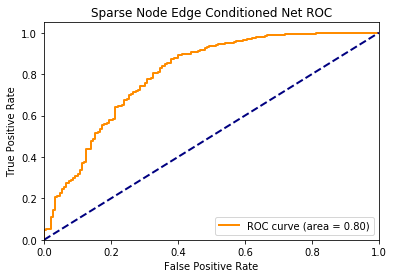

In [8]:
graph_roc_preds(predictions, "Sparse Node Edge Conditioned Net ROC")